## Optimizing Existing Networks

Nengo DL is not confined to opimizing custom made networks, it can also be used to make
existing networks better, or achieve the same result with fewer neurons. What this
example will show is how to train a circular convolution network.

Circular convolution is a key operation used to process [semantic
pointers](http://compneuro.uwaterloo.ca/research/spa/semantic-pointer-architecture.html).
By optimizing this smaller network, larger more complex networks that utilize circular
convolution can benefit.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nengo
import nengo_dl
from nengo.spa import Vocabulary
import tensorflow as tf

To properly train the network, we generate novel training data by randomly generating
semantic pointers.

In [2]:
def gen_pointers(n_inputs, dims, rng):
    vocabulary = Vocabulary(dimensions=dims, rng=rng, max_similarity=1)
    for v in range(n_inputs):
        # keys start with A, second element starts with B, third starts with C
        conv_key = f"C{v}"
        point_key_1 = f"A{v}"
        pointer_1 = vocabulary.create_pointer()
        point_key_2 = f"B{v}"
        pointer_2 = vocabulary.create_pointer()
        vocabulary.add(point_key_1, pointer_1)
        vocabulary.add(point_key_2, pointer_2)
        vocabulary.add(conv_key, vocabulary.parse(point_key_2 + "*" + point_key_1))

    A = np.asarray([vocabulary[f"A{i}"].v for i in range(n_inputs)])[:, None, :]
    B = np.asarray([vocabulary[f"B{i}"].v for i in range(n_inputs)])[:, None, :]
    C = np.asarray([vocabulary[f"C{i}"].v for i in range(n_inputs)])[:, None, :]
    return A, B, C, vocabulary


rng = np.random.RandomState(0)
dimensions = 50
test_a, test_b, test_c, vocab = gen_pointers(10, dimensions, rng)

We want our optimized network to work with spiking LIF neurons, so we will use
SoftLIFRate neurons (a differentiable approximation of LIF neurons) to train the
network.

We'll start with the `nengo.networks.CircularConvolution` network, where all the
parameters are initialized using the standard Nengo methods, and then further optimize
those parameters using deep learning training methods.

In this example only 5 neurons are used per dimension for the circular convolution. This
is fewer than would typically be used in a Nengo model, but the enhanced performance
enabled by the training process will allow the network to function well with this
restricted number of neurons.

In [3]:
with nengo.Network(seed=rng.randint(1e6)) as net:
    net.config[nengo.Ensemble].neuron_type = nengo_dl.SoftLIFRate(sigma=0.1)
    net.config[nengo.Connection].synapse = None

    # Get the raw vectors for the pointers using `vocab['A'].v`
    a = nengo.Node(output=vocab["A0"].v)
    b = nengo.Node(output=vocab["B0"].v)

    # Make the circular convolution network with 5 neurons per dimension
    cconv = nengo.networks.CircularConvolution(5, dimensions=dimensions)

    # Connect the input nodes to the input slots `A` and `B` on the network
    nengo.Connection(a, cconv.input_a)
    nengo.Connection(b, cconv.input_b)

    # Probe the output
    out = nengo.Probe(cconv.output)
    out_filtered = nengo.Probe(cconv.output, synapse=0.01)

We now run the network in its default state to get an idea of the baseline performance.
Ideally the output would be clearly `C0`, the result of the convolution between `A0` and
`B0`, but we can see that it is poorly differentiated.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

/home/tbekolay/Code/nengo-dl/nengo_dl/neurons.py:77: RuntimeWarning: divide by zero encountered in true_divide
  q = np.where(j_valid, np.log1p(1 / z), -js - np.log(self.sigma))
/home/tbekolay/Code/nengo-dl/nengo_dl/neurons.py:77: RuntimeWarning: overflow encountered in true_divide
  q = np.where(j_valid, np.log1p(1 / z), -js - np.log(self.sigma))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0, 0.5, 'dot product')

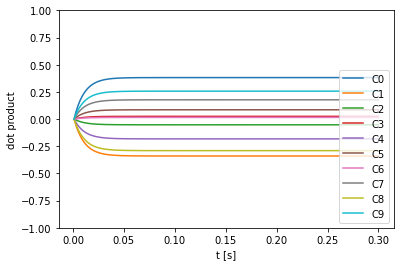

In [4]:
with nengo.Simulator(net) as sim:
    sim.run(0.3)
plt.figure()
output_vocab = vocab.create_subset([f"C{i}" for i in range(10)])
plt.plot(sim.trange(), nengo.spa.similarity(sim.data[out_filtered], output_vocab))
plt.legend(output_vocab.keys, loc=4)
plt.ylim([-1, 1])
plt.xlabel("t [s]")
plt.ylabel("dot product")

Now we can optimize our network, by showing it random input pointers and training it to
output their circular convolution.

In [5]:
with nengo_dl.Simulator(net, minibatch_size=100, device="/cpu:0") as sim:
    optimizer = tf.compat.v1.train.RMSPropOptimizer(5e-3)

    # generate random data
    train_a, train_b, train_c, _ = gen_pointers(1000, dimensions, rng)
    input_feed = {a: train_a, b: train_b}
    output_feed = {out: train_c}

    # train the network for one epoch
    sim.compile(loss="mse", optimizer=optimizer)
    sim.fit(input_feed, output_feed, epochs=100)

    sim.run(0.3)

|#####################Building network (40%)                     | ETA: 0:00:00

/home/tbekolay/Code/nengo-dl/nengo_dl/neurons.py:75: RuntimeWarning: overflow encountered in exp
  z = np.where(js > 30, js, np.log1p(np.exp(js))) * self.sigma
/home/tbekolay/Code/nengo-dl/nengo_dl/neurons.py:77: RuntimeWarning: divide by zero encountered in true_divide
  q = np.where(j_valid, np.log1p(1 / z), -js - np.log(self.sigma))
/home/tbekolay/Code/nengo-dl/nengo_dl/neurons.py:77: RuntimeWarning: overflow encountered in true_divide
  q = np.where(j_valid, np.log1p(1 / z), -js - np.log(self.sigma))


Build finished in 0:00:01                                                      
Optimization finished in 0:00:00                                               
|##############Constructing graph: build stage (63%)             | ETA: 0:00:00

2022-01-21 11:48:39.546632: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Construction finished in 0:00:01                                               
Epoch 1/100
|             Constructing graph: build stage (0%)             | ETA:  --:--:--

/home/tbekolay/Code/nengo-dl/nengo_dl/simulator.py:1024: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


10/10 [==============================] - 2s 22ms/step - loss: 0.0260 - probe_loss: 0.0260 - probe_1_loss: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0191 - probe_loss: 0.0191 - probe_1_loss: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0175 - probe_loss: 0.0175 - probe_1_loss: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0251 - probe_loss: 0.0251 - probe_1_loss: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0309 - probe_loss: 0.0309 - probe_1_loss: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0304 - probe_loss: 0.0304 - probe_1_loss: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0283 - probe_loss: 0.0283 - probe_1_loss: 0.0000e+00
Epoch 8/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0253 - probe_loss: 0.0253 - probe

10/10 [==============================] - 0s 24ms/step - loss: 0.0078 - probe_loss: 0.0078 - probe_1_loss: 0.0000e+00
Epoch 65/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0080 - probe_loss: 0.0080 - probe_1_loss: 0.0000e+00
Epoch 66/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0107 - probe_loss: 0.0107 - probe_1_loss: 0.0000e+00
Epoch 67/100
10/10 [==============================] - 0s 24ms/step - loss: 0.0077 - probe_loss: 0.0077 - probe_1_loss: 0.0000e+00
Epoch 68/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0078 - probe_loss: 0.0078 - probe_1_loss: 0.0000e+00
Epoch 69/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0108 - probe_loss: 0.0108 - probe_1_loss: 0.0000e+00
Epoch 70/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0076 - probe_loss: 0.0076 - probe_1_loss: 0.0000e+00
Epoch 71/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0078 - probe_loss: 0.0078 

After training we run the same test on the network and plot the output. Now we can
clearly see that the output of the network is closest to the ideal output, `C0`.

Text(0, 0.5, 'dot product')

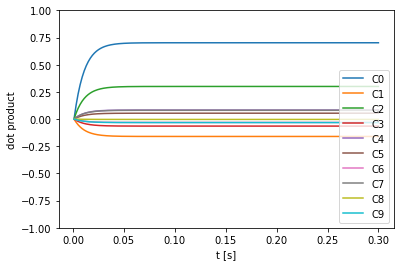

In [6]:
output = sim.data[out_filtered]
plt.figure()
plt.plot(sim.trange(), nengo.spa.similarity(output[0], output_vocab))
plt.legend(output_vocab.keys, loc=4)
plt.ylim([-1, 1])
plt.xlabel("t [s]")
plt.ylabel("dot product")

In a future example we will show how to integrate these training improvements into a
larger network and improve the performance of the network as a whole.